In [1]:
import torch
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("mps")

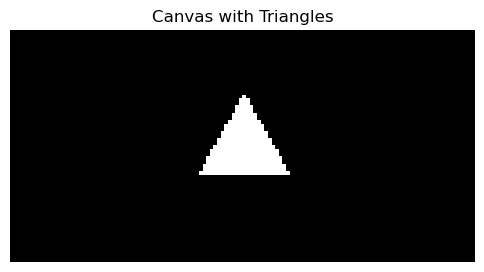

In [8]:
def _generate_equilateral_vertices(h, w, scale):
  center_x, center_y = w / 2, h / 2
  side_length = min(h, w) * 0.8 * scale
  radius = side_length * math.sqrt(3) / 3

  # Calculate the coordinates of the vertices using trigonometry
  vertex1_x = center_x
  vertex1_y = center_y - radius

  vertex2_x = center_x + side_length / 2
  vertex2_y = center_y + (radius / 2)

  vertex3_x = center_x - side_length / 2
  vertex3_y = center_y + (radius / 2)

  return torch.tensor((vertex1_x, vertex1_y)), torch.tensor((vertex2_x, vertex2_y)), torch.tensor((vertex3_x, vertex3_y))

def _point_in_triangle(x, y, v1, v2, v3):
  # Compute barycentric coordinates to determine if point (x, y) is inside the triangle
  b0 = ((v2[1] - v3[1]) * (x - v3[0]) + (v3[0] - v2[0]) * (y - v3[1])) / \
        ((v2[1] - v3[1]) * (v1[0] - v3[0]) + (v3[0] - v2[0]) * (v1[1] - v3[1]))
  b1 = ((v3[1] - v1[1]) * (x - v3[0]) + (v1[0] - v3[0]) * (y - v3[1])) / \
        ((v2[1] - v3[1]) * (v1[0] - v3[0]) + (v3[0] - v2[0]) * (v1[1] - v3[1]))
  b2 = 1 - b0 - b1
  
  return 0 <= b0 <= 1 and 0 <= b1 <= 1 and 0 <= b2 <= 1 

def _fill_triangle(canvas, v1, v2, v3):
  min_x = int(min(v1[0], v2[0], v3[0]))
  max_x = int(max(v1[0], v2[0], v3[0]))
  min_y = int(min(v1[1], v2[1], v3[1]))
  max_y = int(max(v1[1], v2[1], v3[1]))
  # Iterate over each pixel in the bounding box
  for x in range(min_x, max_x + 1):
    for y in range(min_y, max_y + 1):
      # Check if the current pixel is inside the triangle
      if _point_in_triangle(x, y, v1, v2, v3):
        canvas[int(y), int(x)] = 1  # Set pixel to 1 (white)
  return canvas

def generate_equilateral_triangle(h, w, scale):
  canvas = torch.zeros(h, w) 
  v1, v2, v3 = _generate_equilateral_vertices(h, w, scale)
  canvas = _fill_triangle(canvas, v1, v2, v3)
  return canvas

def visualize_canvas(canvas):
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas.squeeze().numpy(), cmap='gray')
    plt.title('Canvas with Triangles')
    plt.axis('off')
    plt.show()

# Example usage:
h, w = 64, 128
scale = 0.5

canvas = generate_equilateral_triangle(h, w, scale)
visualize_canvas(canvas)

In [4]:
class CanvasDataset(Dataset):
  def __init__(self, h, w, scales):
    self.h = h
    self.w = w
    self.scales = scales

  def __len__(self):
    return len(self.scales)  # Assuming scales is a list of input scales

  def __getitem__(self, idx):
    scale = self.scales[idx]
    canvas = generate_equilateral_triangle(self.h, self.w, scale)
    return scale, canvas

# Define the scales for the dataset
scales = np.arange(0.05, 1.01, 0.01, dtype=np.float32)

# Create an instance of the dataset
dataset = CanvasDataset(h=64, w=128, scales=scales)

# Create a dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
class StrokeParametersToImage(nn.Module):
    def __init__(self):
        super(StrokeParametersToImage, self).__init__()
        self.nh = 20
        self.nc = 20
        self.size_x = 128
        self.size_y = 64
        self.main = nn.Sequential(
            nn.BatchNorm1d(1),
            nn.Linear(1, self.nh),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(self.nh),
            nn.Linear(self.nh, self.size_x*self.size_y),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, self.nc, kernel_size=5, padding='same', dilation=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(self.nc),
            nn.Conv2d(self.nc, 1, kernel_size=5, padding='same', dilation=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        x = x.view(-1, 1, self.size_y, self.size_x)
        x = self.conv(x)[:,0]
        return x

In [7]:
model = StrokeParametersToImage()
torch.compile(model)
model.to(device)

# Define your loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# Iterate over your dataset for training
for epoch in range(num_epochs):
    batch_idx = 0
    for scales, triangles in dataloader:
        scales, triangles = scales.to(device), triangles.to(device)
        optimizer.zero_grad()
        output = model(scales.unsqueeze(1))
        # print(output.shape, triangles.shape)
        loss = criterion(output, triangles)  # Define your target here
        loss.backward()
        optimizer.step()

        # Print metrics
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item()}')
        batch_idx += 1

Epoch [1/10], Batch [1/6], Loss: 0.2703823447227478
Epoch [1/10], Batch [2/6], Loss: 0.26819634437561035


KeyboardInterrupt: 

In [ ]:
model.eval()
scale = torch.tensor([0.6], requires_grad=True).unsqueeze(0)
# print(scale.shape)
canvas = model.forward(scale)
print(canvas.grad_fn)
visualize_canvas(canvas.detach())

In [ ]:
device = torch.device("mps")

In [ ]:
class CanvasDataset(Dataset):
  def __init__(self, h, w, scales):
    self.h = h
    self.w = w
    self.scales = scales

  def __len__(self):
    return len(self.scales)  # Assuming scales is a list of input scales

  def __getitem__(self, idx):
    scale = self.scales[idx]
    canvas = generate_equilateral_triangle(self.h, self.w, scale)
    return scale, canvas

# Define the scales for the dataset
scales = np.arange(0.05, 1.01, 0.01, dtype=np.float32)

# Create an instance of the dataset
dataset = CanvasDataset(h=64, w=128, scales=scales)

# Create a dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
model = StrokeParametersToImage()
torch.compile(model)
model.to(DeviceEVICE)

# Define your loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Iterate over your dataset for training
for epoch in range(num_epochs):
    batch_idx = 0
    for scales, triangles in dataloader:
        scales, triangles = scale.to(DEVICE), triangles.to(DEVICE)
        optimizer.zero_grad()
        output = model(scales.unsqueeze(1))
        # print(output.shape, triangles.shape)
        loss = criterion(output, triangles)  # Define your target here
        loss.backward()
        optimizer.step()

        # Print metrics
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item()}')
        batch_idx += 1d

SyntaxError: unmatched ')' (537791267.py, line 14)